In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ctl_300 = xr.open_dataset('/disco/share/mh920/t42_300_ga7_alb0.3_clim.nc')
ctl_1200 = xr.open_dataset('/disco/share/mh920/t42_1200_ga7_alb0.3_clim.nc')
ctl_4800 = xr.open_dataset('/disco/share/mh920/t42_4800_ga7_alb0.3_clim.nc')
ctl_300 = ctl_300.where(ctl_300<1e19,np.nan)
ctl_1200 = ctl_1200.where(ctl_1200<1e19,np.nan)
ctl_4800 = ctl_4800.where(ctl_4800<1e19,np.nan)
weights = np.cos(np.deg2rad(ctl_300.lat))
weights.name = "weights"
land=ctl_300.ml_heat_cap.mean('months') < 8257740
ocean=ctl_300.ml_heat_cap.mean('months') > 8257740

In [18]:
sst = xr.open_dataset('sst_clim_amip.nc',decode_times=False)
sst['sst_clim_amip'] = ctl_300.t_surf.interp(months=sst.time/15.0)

In [19]:
sst

<xarray.Dataset>
Dimensions:        (lat: 180, latb: 181, lon: 360, lonb: 361, time: 12)
Coordinates:
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon            (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * latb           (latb) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lonb           (lonb) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0 360.0
  * time           (time) float64 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
    months         (time) float64 1.0 3.0 5.0 7.0 9.0 ... 17.0 19.0 21.0 23.0
Data variables:
    sst_clim_amip  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [4]:
diff_1200 = ctl_1200-ctl_300
diff_4800 = ctl_4800-ctl_1200

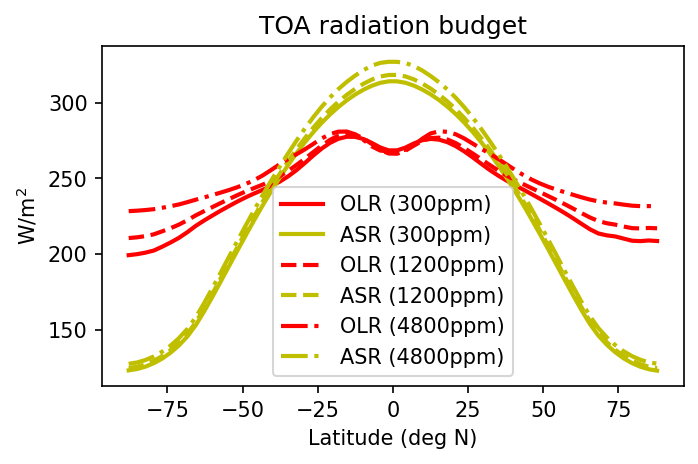

In [8]:
fig = plt.figure(figsize=(5,3),dpi=150)
ctl_300.soc_olr.mean(('lon','months')).plot(c='r',lw=2,label='OLR (300ppm)')
ctl_300.soc_toa_sw.mean(('lon','months')).plot(c='y',lw=2,label='ASR (300ppm)')
ctl_1200.soc_olr.mean(('lon','months')).plot(c='r',ls='--',lw=2,label='OLR (1200ppm)')
ctl_1200.soc_toa_sw.mean(('lon','months')).plot(c='y',ls='--',lw=2,label='ASR (1200ppm)')
ctl_4800.soc_olr.mean(('lon','months')).plot(c='r',ls='-.',lw=2,label='OLR (4800ppm)')
ctl_4800.soc_toa_sw.mean(('lon','months')).plot(c='y',ls='-.',lw=2,label='ASR (4800ppm)')
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$')
plt.title('TOA radiation budget')
plt.legend()
plt.show()

In [9]:
k_TOA = xr.open_dataset('./../socrates_kernels/HadGEM3-GA7.1_TOA_kernel_L19.nc')

In [10]:
p_tropopause= 30000 - 20000 * np.cos(np.deg2rad(k_TOA.lat))

LW_s_fb_1200 = k_TOA.tsurf_lw_cs*diff_1200.t_surf.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon)/ \
               (diff_1200.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
LW_atm_fb_1200 = k_TOA.ta_lw_cs.where(k_TOA.plev>=p_tropopause,0)*diff_1200.temp.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)/ \
                 (diff_1200.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
t_feedback_1200 = LW_s_fb_1200.mean(('month','lon'))+LW_atm_fb_1200.mean('month').mean('lon').sum('plev')

LW_s_fb_4800 = k_TOA.tsurf_lw_cs*diff_4800.t_surf.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon)/ \
               (diff_4800.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
LW_atm_fb_4800 = k_TOA.ta_lw_cs.where(k_TOA.plev>=p_tropopause,0)*diff_4800.temp.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)/ \
                 (diff_4800.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
t_feedback_4800 = LW_s_fb_4800.mean(('month','lon'))+LW_atm_fb_4800.mean('month').mean('lon').sum('plev')

In [11]:
#Code from Qun Liu
from functions import saturation_specific_humidity
q1 = ctl_300.sphum
qdiff = diff_1200.sphum
qs1 = saturation_specific_humidity(ctl_300.temp)
qs2 = saturation_specific_humidity(ctl_300.temp+1.0)
dqs_dT= (qs2 - qs1)
rh = q1/qs1
dq_dT = rh * dqs_dT
dlogq_dT = dq_dT / q1
dlogq = qdiff / q1
divis = dlogq / dlogq_dT
response = k_TOA.q_lw_cs.where(k_TOA.plev>=p_tropopause,0)*divis.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)
wv_feedback_1200 = (response.mean('lon').sum('plev') / diff_1200.mean('lon').t_surf.interp(months=k_TOA.month,lat=k_TOA.lat)).mean('month')

q1 = ctl_1200.sphum
qdiff = diff_4800.sphum
qs1 = saturation_specific_humidity(ctl_1200.temp)
qs2 = saturation_specific_humidity(ctl_1200.temp+1.0)
dqs_dT= (qs2 - qs1)
rh = q1/qs1
dq_dT = rh * dqs_dT
dlogq_dT = dq_dT / q1
dlogq = qdiff / q1
divis = dlogq / dlogq_dT
response = k_TOA.q_lw_cs.where(k_TOA.plev>=p_tropopause,0)*divis.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)
wv_feedback_4800 = (response.mean('lon').sum('plev') / diff_4800.mean('lon').t_surf.interp(months=k_TOA.month,lat=k_TOA.lat)).mean('month')

In [22]:
#Code from Qun Liu
from functions import saturation_specific_humidity
q1 = ctl_300.sphum
qdiff = diff_1200.sphum
qs1 = saturation_specific_humidity(ctl_300.temp)
qs2 = saturation_specific_humidity(ctl_300.temp+1.0)
dqs_dT= (qs2 - qs1)
rh = q1/qs1
dq_dT = rh * dqs_dT
dlogq_dT = dq_dT / q1
dlogq = qdiff / q1
divis = dlogq / dlogq_dT
response = k_TOA.q_sw_cs.where(k_TOA.plev>=p_tropopause,0)*divis.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)
wv_feedback_1200_sw = (response.mean('lon').sum('plev') / diff_1200.mean('lon').t_surf.interp(months=k_TOA.month,lat=k_TOA.lat)).mean('month')

q1 = ctl_1200.sphum
qdiff = diff_4800.sphum
qs1 = saturation_specific_humidity(ctl_1200.temp)
qs2 = saturation_specific_humidity(ctl_1200.temp+1.0)
dqs_dT= (qs2 - qs1)
rh = q1/qs1
dq_dT = rh * dqs_dT
dlogq_dT = dq_dT / q1
dlogq = qdiff / q1
divis = dlogq / dlogq_dT
response = k_TOA.q_sw_cs.where(k_TOA.plev>=p_tropopause,0)*divis.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)
wv_feedback_4800_sw = (response.mean('lon').sum('plev') / diff_4800.mean('lon').t_surf.interp(months=k_TOA.month,lat=k_TOA.lat)).mean('month')

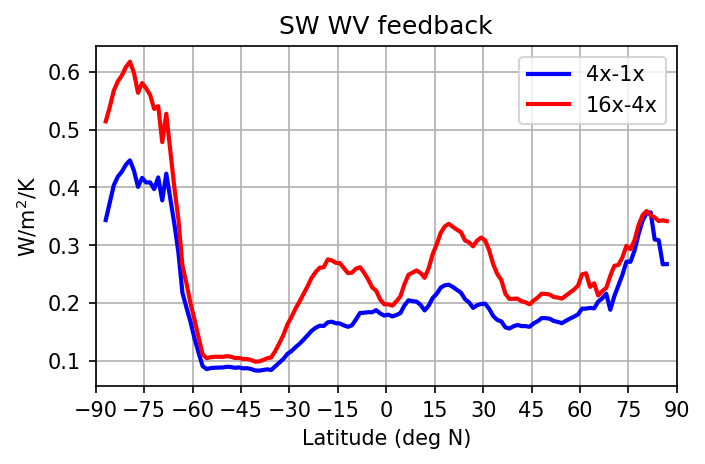

In [23]:
fig = plt.figure(figsize=(5,3),dpi=150)
wv_feedback_1200_sw.plot(lw=2,c='b',label='4x-1x')
wv_feedback_4800_sw.plot(lw=2,c='r',label='16x-4x')
plt.grid()
plt.xticks(np.linspace(-90,90,13))
plt.xlim([-90,90])
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$/K')
plt.title('SW WV feedback')
plt.legend()
plt.show()

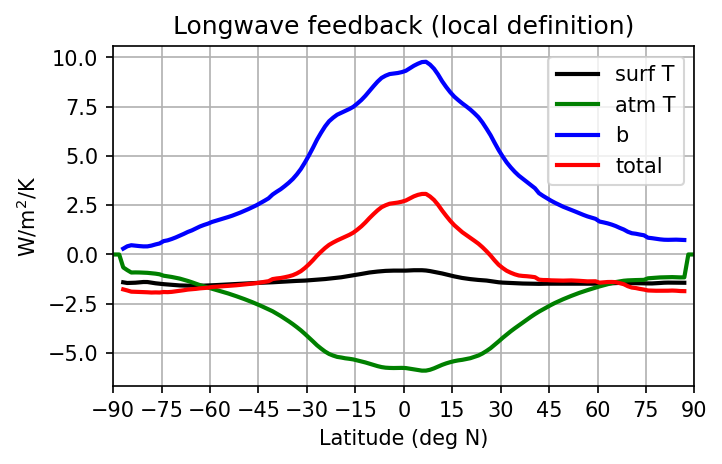

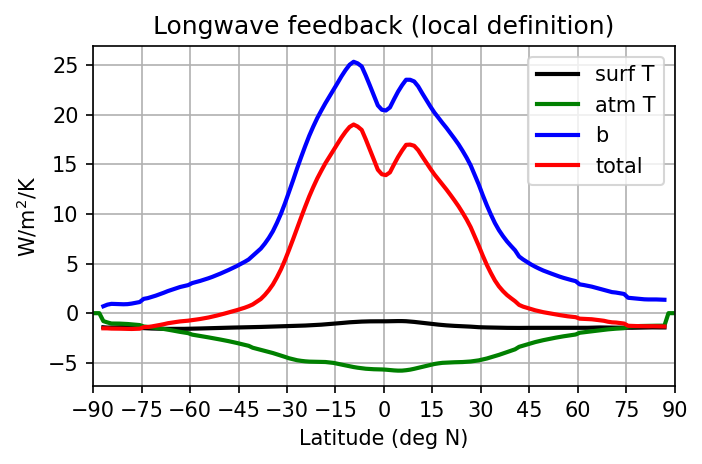

In [15]:
fig = plt.figure(figsize=(5,3),dpi=150)
LW_s_fb_1200.mean(('month','lon')).plot(lw=2,c='k',label='surf T')
(LW_atm_fb_1200.mean('month').mean('lon').sum('plev')).plot(lw=2,c='g',label='atm T')
wv_feedback_1200.plot(lw=2,c='b',label='b')
(t_feedback_1200 + wv_feedback_1200).plot(lw=2,c='r',label='total')
plt.grid()
plt.xticks(np.linspace(-90,90,13))
plt.xlim([-90,90])
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$/K')
plt.title('Longwave feedback (local definition)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(5,3),dpi=150)
LW_s_fb_4800.mean(('month','lon')).plot(lw=2,c='k',label='surf T')
(LW_atm_fb_4800.mean('month').mean('lon').sum('plev')).plot(lw=2,c='g',label='atm T')
wv_feedback_4800.plot(lw=2,c='b',label='b')
(t_feedback_4800 + wv_feedback_4800).plot(lw=2,c='r',label='total')
plt.grid()
plt.xticks(np.linspace(-90,90,13))
plt.xlim([-90,90])
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$/K')
plt.title('Longwave feedback (local definition)')
plt.legend()
plt.show()

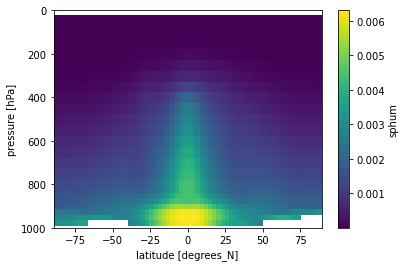

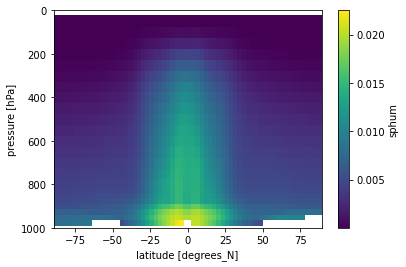

In [18]:
diff_1200.sphum.mean(('months','lon')).plot()
plt.ylim([1000,0])
plt.show()
diff_4800.sphum.mean(('months','lon')).plot()
plt.ylim([1000,0])
plt.show()

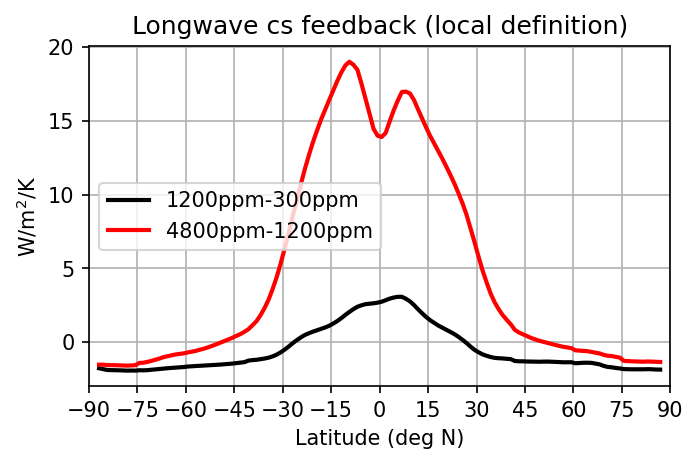

In [21]:
fig = plt.figure(figsize=(5,3),dpi=150)
(t_feedback_1200+wv_feedback_1200).plot(lw=2,c='k',label='1200ppm-300ppm')
(t_feedback_4800+wv_feedback_4800).plot(lw=2,c='r',label='4800ppm-1200ppm')
plt.grid()
plt.xticks(np.linspace(-90,90,13))
plt.xlim([-90,90])
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$/K')
plt.title('Longwave cs feedback (local definition)')
plt.legend()
plt.show()

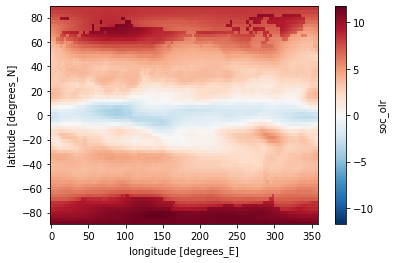

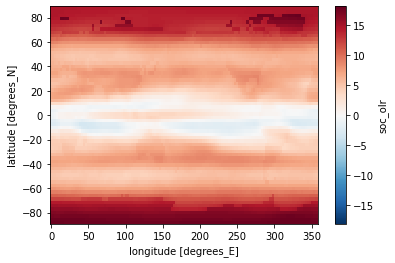

In [24]:
diff_1200.soc_olr.mean(('months')).plot()
plt.show()
diff_4800.soc_olr.mean(('months')).plot()
plt.show()

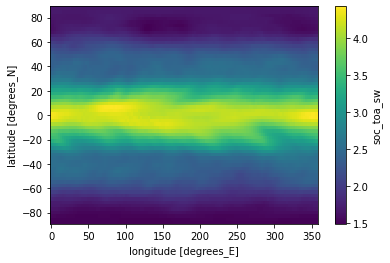

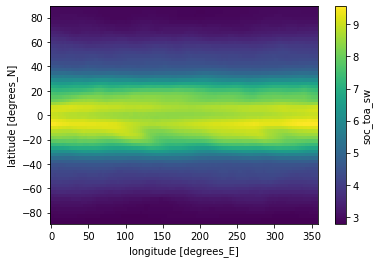

In [26]:
diff_1200.soc_toa_sw.mean(('months')).plot()
plt.show()
diff_4800.soc_toa_sw.mean(('months')).plot()
plt.show()